In [1]:
import netCDF4 as nc
import numpy as np
import iris.coords as coords
import cf_units
import iris.cube as icube
import random
import matplotlib.pyplot as plt
import math
import numpy.ma as ma
import datetime as dt
import iris.plot as iplt
import matplotlib as mpl
import iris
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import genextreme as gev


In [2]:
# import functions from FidelityTest.py
from FidelityTest import calcDistrStatistic, timeseries_fid_test, plot_fidelity_testing, get_cube_limits, plotStatsMeasures 


## 1. load data to iris cube 
* 1) reshape simulations from 3d to 2d
* 2) convert data to iris cube : mod and obs

In [3]:
# load model data
file_path1 = '/Users/evayang/Documents/dissertation/data/Hunan_Jan_tas_model_DePreSys3.nc'  
sim = nc.Dataset(file_path1, mode='r')


In [4]:
# obtain air_temperature data 
air_temperature = sim.variables['air_temperature'][:]
# reshape air_temperature from 3d to 2d to do test later
n_ensembles = air_temperature.shape[1]  
n_months = air_temperature.shape[2]  
model = air_temperature[:].reshape(n_ensembles, -1)
# check shape
print("air_temperature reshape:", model.shape)


air_temperature reshape: (30, 80)


In [5]:
# load observartion temperature data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_Jan_tas_obs_ERA5-Land.nc'  
observations = nc.Dataset(file_path, mode='r')
t2m = observations.variables['t2m'][:]
print("Shape of t2m:", t2m.shape)
# Convert to numpy array
obs_array = np.array(t2m)

Shape of t2m: (30,)


In [6]:
# create obs cube
time_coord = coords.DimCoord(range(t2m.shape[0]), standard_name='time')
if obs_array.ndim > 1:
    year_coord = coords.DimCoord(range(t2m.shape[1]), standard_name='year')
    # define units for each coord
    year_coord.units = cf_units.Unit('years since 1993', calendar='gregorian')
    # cube
    cube = iris.cube.Cube(t2m, dim_coords_and_dims=[(time_coord, 0), (year_coord, 1)])
else:
    obs = iris.cube.Cube(t2m, dim_coords_and_dims=[(time_coord, 0)])
obs.long_name = 'Hunan January Temperature (ERA5-Land)'
obs.units = 'celsius'
obs

Hunan January Temperature (Era5-Land) (celsius),time
Shape,30
Dimension coordinates,
time,x


In [7]:
# create model cube
time_coord = coords.DimCoord(range(model.shape[0]), standard_name='time')
if model.ndim > 1:
    year_coord = coords.DimCoord(range(model.shape[1]), standard_name='realization')
    year_coord.units = cf_units.Unit('years since 1993', calendar='gregorian')
    mod = iris.cube.Cube(model, dim_coords_and_dims=[(time_coord, 0), (year_coord, 1)])
else:
    mod = iris.cube.Cube(model, dim_coords_and_dims=[(time_coord, 0)])
mod.long_name = 'Hunan_Jan_tas_model_DePreSys3'
mod.units = 'celsius'
mod

Hunan Jan Tas Model Depresys3 (celsius),time,realization
Shape,30,80
Dimension coordinates,,
time,x,-
realization,-,x


## 2. Run fidelity test

In [8]:
#calcDistrStatistic(obs.data, mod.data, ['mean', 'std', 'skew', 'kurt', 'linear_trend'], 10000)

In [9]:
stats_measures=timeseries_fid_test(obs,mod)

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 99.99
Standard deviation perc: 13.25
Skewness perc: 51.470000000000006
Kurtosis perc: 68.51
Linear trend perc: 41.86


plotting


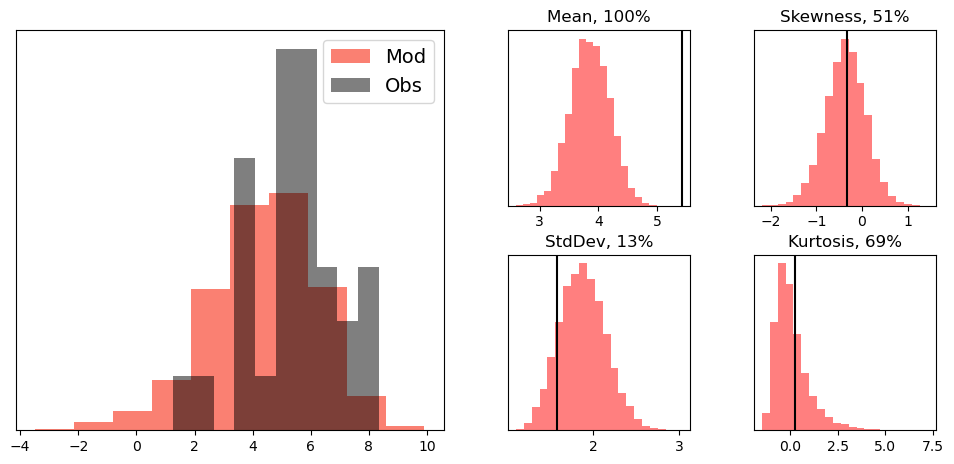

In [10]:
plot_fidelity_testing(obs, mod, stats_measures, 0.1,"fidelity test","1.png")

## 3. Bias correction
* 1) mean bias ratio method: bias correction (not ideal)
* 2) quantile mapping: needs to do moments test? how to do it after the mod data is flatted???

In [11]:
def mean_bias_correction(obs, model):
    """
    Perform mean bias correction on the model data.
    
    Parameters:
    obs (np.array): Observed values, shape (n_months,)
    model (np.array): Model forecast values, shape (n_ensembles, n_months)
    
    Returns:
    np.array: Bias-corrected model values, same shape as input model
    """
    # Calculate the mean across all ensembles and months
    model_mean = np.mean(model)
    obs_mean = np.mean(obs)
    
    # Calculate the correction factor
    correction_factor = obs_mean / model_mean
    
    # Apply the correction factor to the model data
    model_biascor = model * correction_factor
    
    return model_biascor

In [12]:
# bias correction
model_biascor= mean_bias_correction(t2m, model)
# correction factor
print(f'Mean correction factor: {np.mean(t2m)/np.mean(model)}')

Mean correction factor: 1.244248126757738


In [13]:
stats_measures=timeseries_fid_test(obs,model_biascor)

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 93.42
Standard deviation perc: 0.62
Skewness perc: 51.64
Kurtosis perc: 68.45
Linear trend perc: 37.8


plotting


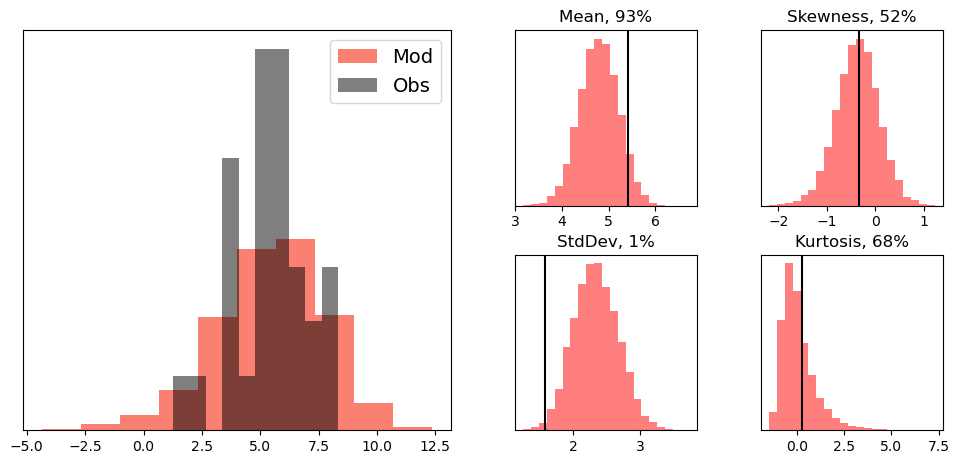

In [14]:
# after bias correction
plot_fidelity_testing(obs, model_biascor, stats_measures, 0.1,"bias correction","2.png")

In [15]:
def plot_temperature_comparison(mod, mod_cor, start_year=1992, end_year=2022):
    """
    Input args:
    mod (iris.cube.Cube): simulations
    mod_cor (iris.cube.Cube): simulations after bias correction
    start_year (int): 1992
    end_year (int): 2022
    """
    years = range(start_year, end_year)
    fig, ax = plt.subplots(figsize=(12, 6))    
#    ax.plot(years, obs, marker='s', label='Observation', color='red', linewidth=2)
    mean1 = mod.data.mean(axis=1) if mod.data.ndim > 1 else mod.data
    std1 = mod.data.std(axis=1) if mod.data.ndim > 1 else np.zeros_like(mean1)
    ax.plot(years, mean1, marker='o', label='Simulation Mean', color='blue')
    ax.fill_between(years, mean1 - std1, mean1 + std1, alpha=0.2, color='blue', label='Simulation ±1 Std Dev')
    
    mean2 = mod_cor.data.mean(axis=1) if mod_cor.data.ndim > 1 else mod_cor.data
    std2 = mod_cor.data.std(axis=1) if mod_cor.data.ndim > 1 else np.zeros_like(mean2)
    ax.plot(years, mean2, marker='s', label='Simulations_biascor Mean', color='red')
    ax.fill_between(years, mean2 - std2, mean2 + std2, alpha=0.2, color='red', label='Simulations_biascor ±1 Std Dev')
    ax.set_title(f'Temperature Comparison: Simulations vs Simulations_biascor ({start_year}-{end_year})')
    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature')
    ax.set_xticks(range(start_year, end_year + 1, 5))
    ax.grid(True, linestyle='-', alpha=0.7)
    ax.legend()
    plt.show()



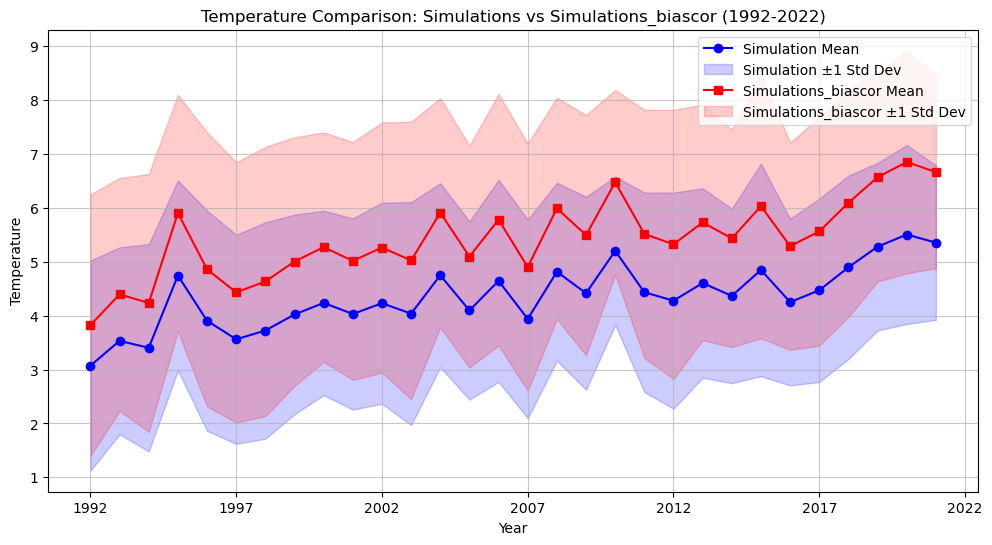

In [16]:
plot_temperature_comparison(mod,model_biascor)

In [17]:
# quantile mapping method
mod_data = mod.data  
obs_data = obs.data  
def calculate_return_periods(data):
    sorted_data = np.sort(data)[::-1]
    ranks = np.arange(1, len(data) + 1)
    return_periods = (len(data) + 1) / ranks
    return sorted_data, return_periods
obs_sorted, obs_return_periods = calculate_return_periods(obs_data)
unseen_flat = mod_data.flatten()  # flatten: 2400
unseen_sorted, unseen_return_periods = calculate_return_periods(unseen_flat)

# gev fit
gev_params = gev.fit(obs_data) #get parameters 
return_periods = np.logspace(0, np.log10(30*80), 100)
gev_quantiles = gev.ppf(1 - 1/return_periods, *gev_params)

# Qmap
def qmap(obs, mod):
    obs_sorted = np.sort(obs)
    mod_sorted = np.sort(mod)
    obs_quantiles = np.linspace(0, 1, len(obs_sorted)) 
    mod_quantiles = np.linspace(0, 1, len(mod_sorted))
    return np.interp(mod_quantiles, obs_quantiles, obs_sorted)
unseen_qmap = qmap(obs_data, unseen_flat)
unseen_qmap_sorted, unseen_qmap_return_periods = calculate_return_periods(unseen_qmap)

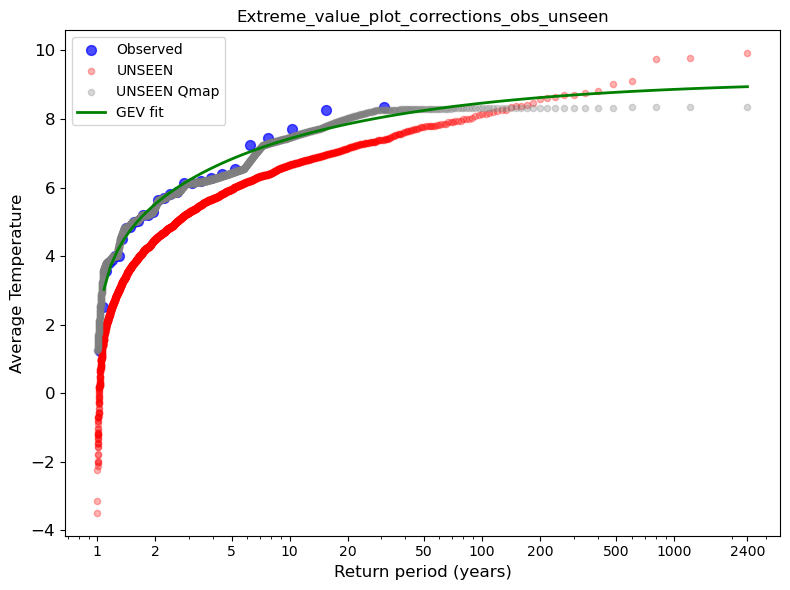

In [18]:
#plot 
plt.figure(figsize=(8, 6))
plt.scatter(obs_return_periods, obs_sorted, label='Observed', color='blue', alpha=0.7, s=50)
plt.scatter(unseen_return_periods, unseen_sorted, label='UNSEEN', color='red', alpha=0.3, s=20)
plt.scatter(unseen_qmap_return_periods, unseen_qmap_sorted, label='UNSEEN Qmap', color='grey', alpha=0.3, s=20)
plt.plot(return_periods, gev_quantiles, label='GEV fit', color='green', linewidth=2)
plt.xscale('log')
plt.xlabel('Return period (years)', fontsize=12)
plt.ylabel('Average Temperature', fontsize=12)
plt.title('Extreme_value_plot_corrections_obs_unseen', fontsize=12)
x_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000,2400]
plt.xticks(x_ticks, x_ticks, fontsize=10)
plt.legend(fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()